In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression

%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 3]

In [2]:
def plot_scatter(stat, ax, xcolumn, ycolumn):    
    ax.scatter(stat[xcolumn].values, stat[ycolumn].values)
    ax.plot(stat[xcolumn], linear_regression(stat, xcolumn, ycolumn), color='red')

    ax.set_xlabel(xcolumn, fontsize=12)
    ax.set_ylabel(ycolumn, fontsize=12)
    
    ax.hlines(0, stat[xcolumn].min(), stat[xcolumn].max(), linestyles='dashed', alpha=0.3)

In [3]:
def linear_regression(data, x_name, y_name):
    X = data.loc[:, x_name].values.reshape(-1, 1)  # values converts it into a numpy array
    Y = data.loc[:, y_name].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
    linear_regressor = LinearRegression().fit(X, Y)  # create object for the class
    print(f'r_sqr value: {linear_regressor.score(X, Y)}')
    return linear_regressor.predict(X)

In [4]:
path = '/Users/berg/Projects/Atto/moc_imbalance_flip/data/positions'

In [5]:
cwd = os.getcwd()
df = pd.read_csv(path + '/hold_60000_volume_2000000_spread_0.2_deltaimb_1_date_2020-11-18.csv', index_col=0)#, parse_dates=True)
df.head()

,date,moc_date,symbol,volume,start,stop,initial_imb,paired_imb,direction,open_price,...,position_size,position_size_bp,reverse_count,imbBeforeReversePct,imbAfterReversePct,deltaImbPct,delta_move,delta_move_pct,position_pnl_bp,position_pnl
0,2020-02-03,2020-02-04,ABBV,7916750,2020-02-03 15:55:00,2020-02-03 15:56:00,-295275,777818,Long,82.22,...,500,500.000000,1,-3.729750,0.119582,3.849332,0.05,0.060812,25.000000,25.00
1,2020-02-03,2020-02-04,ABEV,15315378,2020-02-03 15:59:36,2020-02-03 16:00:00,131846,270056,Short,4.12,...,407533,12135.922330,1,0.860873,-0.729620,-1.590493,-0.01,-0.242718,-121.359223,-4075.33
2,2020-02-03,2020-02-04,ACM,1262740,2020-02-03 15:55:00,2020-02-03 15:56:00,-6736,380765,Long,47.64,...,803,803.000000,1,-0.533443,0.990940,1.524383,0.01,0.020991,8.030000,8.03
3,2020-02-03,2020-02-04,ACN,1880650,2020-02-03 15:55:00,2020-02-03 15:56:00,-62724,330947,Long,207.69,...,340,240.743416,1,-3.335230,1.766145,5.101375,-0.02,-0.009630,-4.814868,-6.80
4,2020-02-03,2020-02-04,ADM,2913957,2020-02-03 15:59:07,2020-02-03 16:00:00,-33015,423259,Long,44.98,...,3599,1111.605158,1,-1.132995,0.061257,1.194252,-0.02,-0.044464,-22.232103,-71.98


## Data overview

In [6]:
df.describe()

,volume,initial_imb,paired_imb,open_price,spread_at_open,close_price,spread_at_close,max_pnl_price,min_pnl_price,position_size,position_size_bp,reverse_count,imbBeforeReversePct,imbAfterReversePct,deltaImbPct,delta_move,delta_move_pct,position_pnl_bp,position_pnl
count,1.839700e+04,1.839700e+04,1.839700e+04,18397.000000,18397.000000,18397.000000,18397.000000,18397.000000,18397.000000,1.839700e+04,18397.000000,18397.000000,1.839700e+04,1.839700e+04,1.839700e+04,1.839700e+04,1.839700e+04,1.839700e+04,1.839700e+04
mean,4.976532e+06,-2.142712e+03,6.550178e+05,51.883721,0.021980,51.883579,0.012564,51.884976,51.881848,1.402954e+04,2564.205034,2.675001,NaN,NaN,NaN,4.645605e-03,-3.423325e-02,-1.266928e+01,-9.550557e+01
std,6.372828e+06,2.819294e+05,1.634591e+06,55.689958,0.027392,55.689060,0.029913,55.693843,55.687208,5.828751e+04,6761.593170,4.297406,NaN,NaN,NaN,1.641116e-01,3.704323e-01,1.199007e+02,8.179850e+02
min,0.000000e+00,-8.983242e+06,0.000000e+00,0.120000,0.010000,0.130000,-0.660000,0.120000,0.000000,1.000000e+00,1.000000,1.000000,-inf,-inf,-inf,-2.970000e+00,-1.047368e+01,-3.975535e+03,-3.253792e+04
25%,2.096450e+06,-3.064600e+04,1.561190e+05,14.800000,0.010000,14.810000,0.000000,14.800000,14.810000,3.970000e+02,320.000000,1.000000,-9.714219e-01,-8.504376e-01,-1.811392e+00,-3.000000e-02,-1.152738e-01,-3.915000e+01,-5.988000e+01
50%,3.272747e+06,1.040000e+02,3.021850e+05,33.240000,0.010000,33.250000,0.010000,33.250000,33.220000,1.297000e+03,945.358291,1.000000,3.343209e-03,-4.440639e-03,-1.003163e+00,-8.881784e-16,-1.797932e-14,-7.476249e-12,-8.038104e-11
75%,5.485268e+06,3.214300e+04,6.036660e+05,66.060000,0.020000,66.090000,0.010000,66.090000,66.060000,6.044000e+03,2698.327037,2.000000,9.728777e-01,8.755594e-01,1.814129e+00,3.000000e-02,7.545272e-02,2.008000e+01,2.421000e+01
max,1.385543e+08,1.491420e+07,5.953006e+07,499.180000,0.200000,499.370000,0.670000,498.920000,499.500000,1.363849e+06,294117.647059,55.000000,inf,inf,inf,4.280000e+00,6.331471e+00,3.165736e+03,2.683076e+04


Some zero values in column `volume` even though we have filtered on the query level over `DailyShares` - average volume more than 2 mln shares. Drop these rows.

In [7]:
df = df[df['volume']>0]
df.describe()

,volume,initial_imb,paired_imb,open_price,spread_at_open,close_price,spread_at_close,max_pnl_price,min_pnl_price,position_size,position_size_bp,reverse_count,imbBeforeReversePct,imbAfterReversePct,deltaImbPct,delta_move,delta_move_pct,position_pnl_bp,position_pnl
count,1.837000e+04,1.837000e+04,1.837000e+04,18370.000000,18370.000000,18370.000000,18370.000000,18370.000000,18370.000000,1.837000e+04,18370.000000,18370.000000,18370.000000,18370.000000,18370.000000,1.837000e+04,1.837000e+04,1.837000e+04,1.837000e+04
mean,4.983847e+06,-2.149968e+03,6.559117e+05,51.944277,0.021971,51.944132,0.012550,51.945551,51.942423,1.404061e+04,2562.787354,2.677463,-0.122325,0.075230,0.197555,4.703059e-03,-3.365981e-02,-1.256311e+01,-9.539785e+01
std,6.374651e+06,2.821257e+05,1.635621e+06,55.705631,0.027370,55.704736,0.029904,55.709514,55.702869,5.832663e+04,6764.537121,4.300083,7.506272,4.385699,9.849328,1.642079e-01,3.694567e-01,1.198441e+02,8.183874e+02
min,1.125830e+05,-8.983242e+06,0.000000e+00,0.120000,0.010000,0.130000,-0.660000,0.120000,0.000000,1.000000e+00,1.000000,1.000000,-826.165919,-53.923850,-108.393915,-2.970000e+00,-1.047368e+01,-3.975535e+03,-3.253792e+04
25%,2.100965e+06,-3.070100e+04,1.565902e+05,14.872500,0.010000,14.852500,0.000000,14.862500,14.860000,3.962500e+02,320.000000,1.000000,-0.969371,-0.850375,-1.811268,-3.000000e-02,-1.148907e-01,-3.909826e+01,-5.980000e+01
50%,3.278201e+06,1.190000e+02,3.027420e+05,33.290000,0.010000,33.300000,0.010000,33.325000,33.280000,1.296000e+03,945.089792,1.000000,0.003916,-0.004940,-1.003525,-2.220446e-16,-1.156036e-14,-3.415490e-12,-3.415490e-12
75%,5.488139e+06,3.220025e+04,6.041848e+05,66.202500,0.020000,66.195000,0.010000,66.210000,66.210000,6.047000e+03,2696.871629,2.000000,0.972438,0.872571,1.812005,3.000000e-02,7.548238e-02,2.017228e+01,2.435000e+01
max,1.385543e+08,1.491420e+07,5.953006e+07,499.180000,0.200000,499.370000,0.670000,498.920000,499.500000,1.363849e+06,294117.647059,55.000000,81.669285,381.543117,827.447462,4.280000e+00,6.331471e+00,3.165736e+03,2.683076e+04


array([[<AxesSubplot:title={'center':'volume'}>,
        <AxesSubplot:title={'center':'deltaImbPct'}>,
        <AxesSubplot:title={'center':'spread_at_open'}>],
       [<AxesSubplot:title={'center':'position_size_bp'}>,
        <AxesSubplot:title={'center':'delta_move'}>,
        <AxesSubplot:title={'center':'position_pnl_bp'}>]], dtype=object)

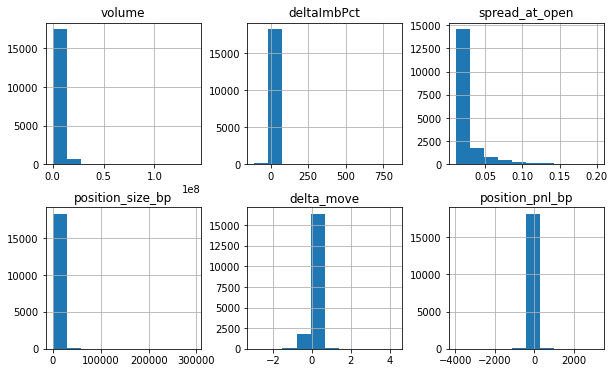

In [8]:
df.hist(column=['volume', 'deltaImbPct', 'spread_at_open', 'position_size_bp', 'delta_move', 'position_pnl_bp'], layout=(2,3), figsize=(10,6))

Now min `volume` is more than 100k. It is still far below our threshold at 2 mln. But let's leave it as it is until we can prove some reliable relationship between pnl and volume. 

At least there is `spread_at_open` column which is complementary and far more important and it distributes as expected with max spread at 20 cents. Let's check other important columns. 

The cheapest stock `open_price` was at 12 cents and the most expensive at 499 dollars. 

`deltaImbPct` has some tails but 25 and 75 percentiles are okay.

`deltaMove` which is a proxy of our pnl looks good, from -2.97 to 4.28 dollars. 

`position_size_bp` and `position_size` are subjects for deeper investigation. Max values are equal to 1.3 mln and 300k shares respectively seems a "little bit" risky and may skew our `position_pnl_bp` and `position_pnl` significantly. Before we dive deeper into this analysis, it is worth mentioning how I calculate these columns:
`position_size` is simply Bid/Aks size depending on direction of a position.
`position_size_bp` is *min* value among two: `position_size` or bp (buying power, default 50k) divided by `open_price`. In this case price is proxy for volatility. The assumption is the more expensive stock the higher is volatility. It is true for most cases. But even with this limitation, it seems like we get some outliers that may skew the results as we can see that *mean* `delta_move` is positive and `pnl`s are highly negative. Meaning that **sizing is highly important!**

In [9]:
# Add absolute columns  
df[['abs_deltaImbPct', 'abs_imbBeforeReversePct', 'abs_imbAfterReversePct', 'abs_position_pnl_bp', 'abs_delta_move']] = df[['deltaImbPct', 'imbBeforeReversePct', 'imbAfterReversePct', 'position_pnl_bp', 'delta_move']].apply(lambda column: abs(column), axis=0)

## Price and size analysis

Let's check relation between `position_size_bp` and `position_pnl_bp`. What I expect to see is obviously with the rise of size there is the rise of absolute pnl

r_sqr value: 0.3394726086104327
r_sqr value: 0.24064710430451763


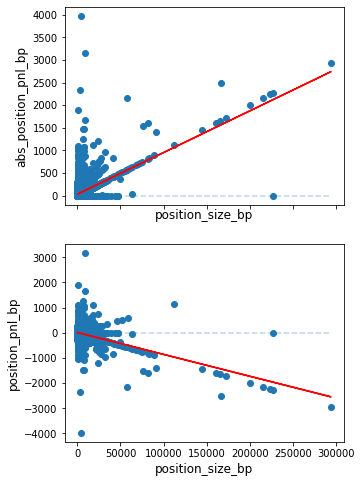

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5,8))
plot_scatter(df, ax1, 'position_size_bp', 'abs_position_pnl_bp')
plot_scatter(df, ax2, 'position_size_bp', 'position_pnl_bp')

Wow! From the first scatter plot we realize that there is a relationship between size and pnl. But what is more interesting is that we get a bunch of losses where the `position_size_bp` is more than 50k. This may be due to such *phenomenon as we trade cheap stocks around let's say 1 dollar price and we lose 1 or a few cents which lead to huge losses.* 

What I will do next is to confirm the hypothesis above. I want to find out if cheaper price leads to more negative pnl and vice versa. In other words, I want to see more clearly how the average pnl changes with the size. For that, I will use binning - define the arbitrary number of quantiles and let pandas figure out how to divide up the data. 

In [11]:
# Pnl and size bins
size_groups = 10
df['size_group'] = pd.qcut(df['position_size_bp'], size_groups, labels=list(range(1, size_groups+1)))
df_size_group = pd.DataFrame()
df_size_group['count'] = df.groupby('size_group')['position_pnl_bp'].count()
df_size_group['avg_pnl'] = df.groupby('size_group')['position_pnl_bp'].mean()
df_size_group['sum_pnl'] = df.groupby('size_group')['position_pnl_bp'].sum()
df_size_group['min_size'] = df.groupby('size_group')['position_size_bp'].min()
df_size_group['max_size'] = df.groupby('size_group')['position_size_bp'].max()
df_size_group['quantile10_size'] = df.groupby('size_group')['position_size_bp'].quantile(0.1)
df_size_group['quantile90_size'] = df.groupby('size_group')['position_size_bp'].quantile(0.9)
df_size_group['avg_size'] = df.groupby('size_group')['position_size_bp'].mean()
df_size_group['min_price'] = df.groupby('size_group')['open_price'].min()
df_size_group['max_price'] = df.groupby('size_group')['open_price'].max()
df_size_group['quantile10_price'] = df.groupby('size_group')['open_price'].quantile(0.1)
df_size_group['quantile90_price'] = df.groupby('size_group')['open_price'].quantile(0.9)
df_size_group['avg_price'] = df.groupby('size_group')['open_price'].mean()
df_size_group

,count,avg_pnl,sum_pnl,min_size,max_size,quantile10_size,quantile90_size,avg_size,min_price,max_price,quantile10_price,quantile90_price,avg_price
size_group,,,,,,,,,,,,,
1,1844,2.879141,5309.136410,1.000000,150.000000,32.300000,121.000000,93.185984,0.46,499.18,33.643,214.918,112.445011
2,1830,5.178988,9477.547191,151.000000,272.672738,181.084426,248.000000,207.473590,0.25,327.02,33.769,227.439,117.907710
3,1837,2.312780,4248.577749,273.000000,401.574171,299.976005,400.000000,336.185767,0.17,183.12,26.244,155.008,83.104110
4,1838,1.822222,3349.244055,401.670951,629.000000,422.000000,601.000000,517.547554,0.17,124.48,21.600,104.012,63.874075
5,1836,1.940448,3562.663319,629.009938,945.000000,660.033003,903.000000,782.338792,0.28,79.49,19.835,71.615,47.987206
6,1862,-0.123536,-230.023383,945.179584,1400.000000,991.099926,1360.900000,1177.281409,0.49,52.90,18.054,48.689,35.393695
7,1812,-4.411484,-7993.609539,1400.168020,2146.844139,1454.333915,2062.621211,1743.019347,0.29,35.71,15.042,33.820,25.677848
8,1839,-10.306731,-18954.078301,2148.000000,3410.641201,2247.191011,3234.152652,2718.238409,0.34,23.27,11.544,21.892,17.195421
9,1835,-24.350129,-44682.486776,3412.969283,5700.000000,3584.229391,5319.148936,4436.097538,0.41,14.65,8.504,13.770,10.806796


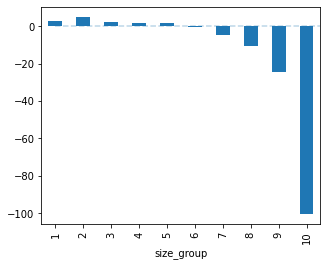

In [12]:
# Plot
fig, (ax1) = plt.subplots(1, 1, figsize=(5,4))
df_size_group['avg_pnl'].plot.bar(ax=ax1)
ax1.hlines(0, 0, 10, linestyles='dashed', alpha=0.3)

There is an equal number of observations/positions in each bin. And that the higher size in cheaper stocks leads to highly negative results. So, let's define our threshold. The first 5 groups are positive on pnl. I will take 90% percentile of size as my upper threshold for volume and 10% percentile of price as my bottom threshold for price.
If we round these numbers we will get: **max_volume = 900** shares and **min_price = 20 dollars**.

In [13]:
# Filter
max_volume = 900 
min_price = 20 
df_filter_vp = df[(df['position_size_bp'] <= max_volume) & (df['open_price'] >= min_price)].copy()

<AxesSubplot:>

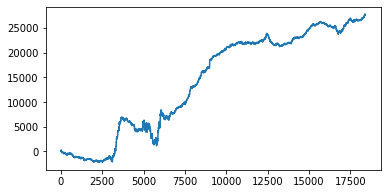

In [14]:
# Plot
fig, ax = plt.subplots(1,1)
df_filter_vp['position_pnl_bp'].cumsum().plot(ax=ax)

In [15]:
sharpe_vp = df_filter_vp['position_pnl_bp'].mean()/df_filter_vp['position_pnl_bp'].std()
print('Sharpe with next filters: max position size {} shares, min price ${} is \n{}'.format(max_volume, min_price, sharpe_vp))

Sharpe with next filters: max position size 900 shares, min price $20 is 
0.04708252847368983


## MAE/MFE

*Maximum Adverse Excursion (MAE)* - the MAE is the largest experienced loss during a trade; it measures how far price went against you.

*Maximum Favorable Excursion (MFE)* - the MFE is the opposite of the MAE and it measures the largest observed profit during a trade.

It is useful to understand the MAE and MFE of trades in order to inform the setting of stop and take profit levels. In reality, I find these metrics to be more useful from an academic perspective rather than a practical one, as often the placement of stops and take profit levels is dependent on volatility, and thus examination of MAE and MFE without considering volatility is of limited use. Still, visualizing these metrics can quickly alert you as to whether there is something drastically wrong with your strategy’s exit conditions. 

Timing columns:`start`, `stop`, `max_pnl_time`, `min_pnl_time`

Price column: `open_price`, `close_price`, `max_pnl_price`, `min_pnl_price`

In [93]:
# MAE
df_filter_vp.loc[df_filter_vp['direction'] == 'Long', 'delta_move_mae'] = df_filter_vp['min_pnl_price'] - df_filter_vp['open_price'] 
df_filter_vp.loc[df_filter_vp['direction'] == 'Short', 'delta_move_mae'] = df_filter_vp['open_price'] - df_filter_vp['min_pnl_price']
# MFE
df_filter_vp.loc[df_filter_vp['direction'] == 'Long', 'delta_move_mfe'] = df_filter_vp['max_pnl_price'] - df_filter_vp['open_price'] 
df_filter_vp.loc[df_filter_vp['direction'] == 'Short', 'delta_move_mfe'] = df_filter_vp['open_price'] - df_filter_vp['max_pnl_price']

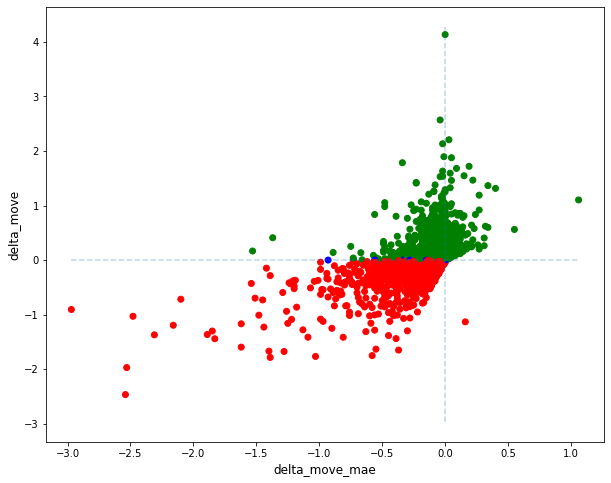

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
xcolumn = 'delta_move_mae'
ycolumn = 'delta_move'
col = np.where(df_filter_vp[ycolumn].values < 0,'r',np.where(df_filter_vp[ycolumn].values > 0,'g','b'))
ax.scatter(df_filter_vp[xcolumn].values, df_filter_vp[ycolumn].values, c=col)
ax.set_xlabel(xcolumn, fontsize=12)
ax.set_ylabel(ycolumn, fontsize=12)
ax.hlines(0, df_filter_vp[xcolumn].min(), df_filter_vp[xcolumn].max(), linestyles='dashed', alpha=0.3)
ax.vlines(0, df_filter_vp[ycolumn].min(), df_filter_vp[ycolumn].max(), linestyles='dashed', alpha=0.3)

In [98]:
len(df_filter_vp.loc[(df_filter_vp['direction']=='Long') & (df_filter_vp['max_pnl_price']<df_filter_vp['close_price']), ['date', 'start', 'symbol', 'direction', 'open_price', 'max_pnl_price', 'min_pnl_price', 'close_price', 'close_status']])

260

On the horizontal axis, we have the trade MAE in pct. On the vertical axis, we have the trade final profit in pct. Red dots denote losing trades; green dots denote winning trades. We can see that all the trades that lie above zero on the vertical axis are thus represented as green dots, and those lying below zero as red dots.  Notice that there is a diagonally downwards sloping invisible line that appears to act as a hard limit – there are no red dots below this line. Of course, dots that lie along this line represent trades whose MAE is equal to their final result – that is, they were closed at the worst possible time. 

...

That means that we could make our stop loss slightly wider than this MAE and not stop out any winning trades at all, however, all the losing trades that lost more than X pct would be limited to losing only X pct (plus slippage). 

The same but in pnl measures. The assumption we make here is that our pnl already incorporates volatility. We could suggest stop loss on pnl as a function of bp (buying power). 

In [99]:
df_filter_vp['position_pnl_bp_mae'] = df_filter_vp['delta_move_mae'] * df_filter_vp['position_size_bp']
df_filter_vp['position_pnl_bp_mfe'] = df_filter_vp['delta_move_mfe'] * df_filter_vp['position_size_bp']

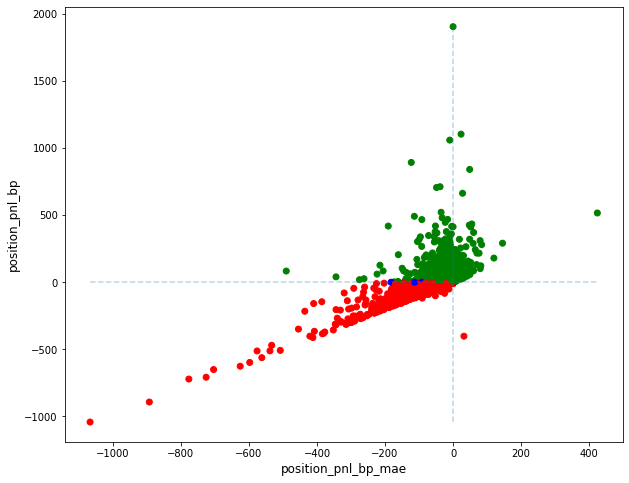

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
xcolumn = 'position_pnl_bp_mae'
ycolumn = 'position_pnl_bp'
col = np.where(df_filter_vp[ycolumn].values < 0,'r',np.where(df_filter_vp[ycolumn].values > 0,'g','b'))
ax.scatter(df_filter_vp[xcolumn].values, df_filter_vp[ycolumn].values, c=col)
ax.set_xlabel(xcolumn, fontsize=12)
ax.set_ylabel(ycolumn, fontsize=12)
ax.hlines(0, df_filter_vp[xcolumn].min(), df_filter_vp[xcolumn].max(), linestyles='dashed', alpha=0.3)
ax.vlines(0, df_filter_vp[ycolumn].min(), df_filter_vp[ycolumn].max(), linestyles='dashed', alpha=0.3)

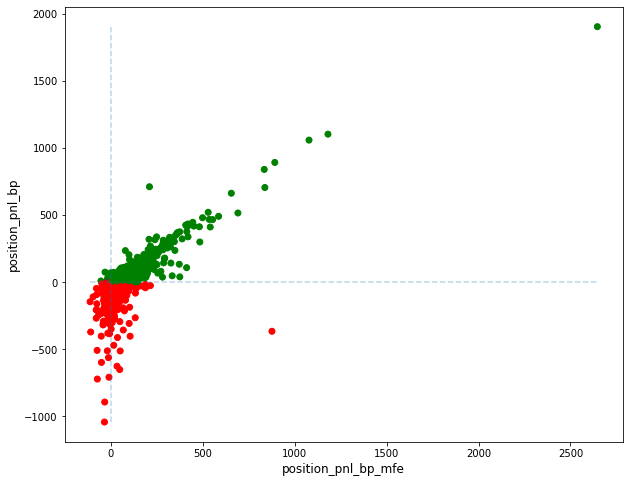

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
xcolumn = 'position_pnl_bp_mfe'
ycolumn = 'position_pnl_bp'
col = np.where(df_filter_vp[ycolumn].values < 0,'r',np.where(df_filter_vp[ycolumn].values > 0,'g','b'))
ax.scatter(df_filter_vp[xcolumn].values, df_filter_vp[ycolumn].values, c=col)
ax.set_xlabel(xcolumn, fontsize=12)
ax.set_ylabel(ycolumn, fontsize=12)
ax.hlines(0, df_filter_vp[xcolumn].min(), df_filter_vp[xcolumn].max(), linestyles='dashed', alpha=0.3)
ax.vlines(0, df_filter_vp[ycolumn].min(), df_filter_vp[ycolumn].max(), linestyles='dashed', alpha=0.3)

This time, the MFE of the trade is plotted on the horizontal axis and the final profit or loss of the trade is again on the vertical axis. Now we have an upwards sloping line that acts as a barrier, which represents those trades that were closed at their maximum profitability (remember in this strategy we use a time-based exit by default). We can see that many of our losing trades were actually profitable for some part of their lives – some of them significantly so.

Now we are faced with the dilemma of whether to include a take profit level and if so, at which level to place it. If we make it tight, we will convert a lot of losing trades into winners, but at the same time we will reduce the profit of many of our bigger winners. 

In [66]:
df_filter_vp['delta_time'] = pd.to_datetime(df_filter_vp['max_pnl_time']) - pd.to_datetime(df_filter_vp['min_pnl_time']) 
df_filter_vp['delta_time'] = df_filter_vp['delta_time'].dt.total_seconds()

<AxesSubplot:>

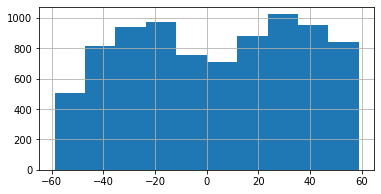

In [68]:
df_filter_vp['delta_time'].hist()

## Imbalance delta analysis

Let's apply same analysis to see if `abs_deltaImbPct`

In [16]:
# Pnl and size bins
imb_groups = 8
df_filter_vp['imb_group'] = pd.qcut(df['abs_deltaImbPct'], imb_groups, labels=list(range(1, imb_groups+1)))
df_imb_group = pd.DataFrame()
df_imb_group['count'] = df_filter_vp.groupby('imb_group')['position_pnl_bp'].count()
df_imb_group['avg_pnl'] = df_filter_vp.groupby('imb_group')['position_pnl_bp'].mean()
df_imb_group['sum_pnl'] = df_filter_vp.groupby('imb_group')['position_pnl_bp'].sum()
df_imb_group['min_size'] = df_filter_vp.groupby('imb_group')['abs_deltaImbPct'].min()
df_imb_group['max_size'] = df_filter_vp.groupby('imb_group')['abs_deltaImbPct'].max()
df_imb_group['quantile10_size'] = df_filter_vp.groupby('imb_group')['abs_deltaImbPct'].quantile(0.1)
df_imb_group['quantile90_size'] = df_filter_vp.groupby('imb_group')['abs_deltaImbPct'].quantile(0.9)

df_imb_group

,count,avg_pnl,sum_pnl,min_size,max_size,quantile10_size,quantile90_size
imb_group,,,,,,,
1,1021,-3.245416,-3313.569979,1.000117,1.119787,1.011212,1.106505
2,1056,-1.157116,-1221.914193,1.120054,1.283195,1.132189,1.263865
3,1068,2.384674,2546.831572,1.283991,1.502186,1.305342,1.477096
4,1081,-0.118828,-128.453099,1.503855,1.811666,1.528658,1.774887
5,1026,1.650784,1693.704648,1.811977,2.282558,1.842466,2.232356
6,1080,2.199509,2375.469661,2.283403,3.062763,2.343639,2.946430
7,1056,9.390150,9915.998396,3.063999,4.912963,3.174607,4.642808
8,1015,15.601299,15835.318885,4.914437,155.659856,5.281031,17.660246


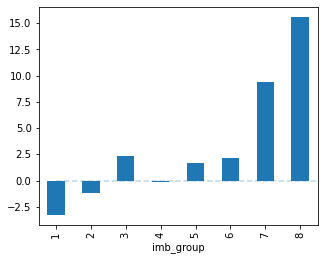

In [17]:
# Plot
fig, (ax1) = plt.subplots(1, 1, figsize=(5,4))
df_imb_group['avg_pnl'].plot.bar(ax=ax1)
ax1.hlines(0, 0, 8, linestyles='dashed', alpha=0.3)

Awesome! Another clear confirmation of our hypothesis. With more significant reversal we get better and better pnl. From group 5 the pnl becomes consistently positive. From group 7 it becomes much better. So, we can take both into consideration. The last one can be more conservative one. Let's define our thresholds for `abs_deltaImbPct`: **min_deltaImbPct = 1.8** and **min_deltaImbPct_conservative = 3**

In [18]:
# Filter
min_deltaImbPct = 1.8
min_deltaImbPct_conservative = 3
df_filter_vpi = df_filter_vp[df_filter_vp['abs_deltaImbPct'] > min_deltaImbPct].copy()
df_filter_vpi_conservative = df_filter_vp[df_filter_vp['abs_deltaImbPct'] > min_deltaImbPct_conservative].copy()

<AxesSubplot:>

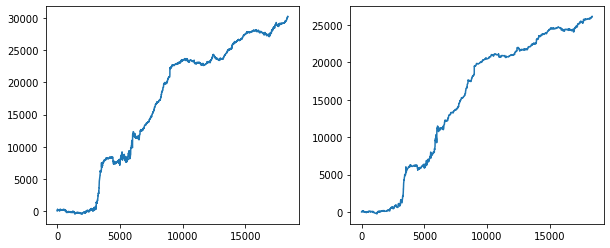

In [19]:
# Plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
df_filter_vpi['position_pnl_bp'].cumsum().plot(ax=ax1)
df_filter_vpi_conservative['position_pnl_bp'].cumsum().plot(ax=ax2)

In [20]:
sharpe_vpi = df_filter_vpi['position_pnl_bp'].mean()/df_filter_vpi['position_pnl_bp'].std()
sharpe_vpi_conservative = df_filter_vpi_conservative['position_pnl_bp'].mean()/df_filter_vpi_conservative['position_pnl_bp'].std()
print('Sharpe with next filters: max position size {} shares, min price ${}, min delta imbalance pct {}% is \n{}'.format(max_volume, min_price, min_deltaImbPct, sharpe_vp))
print('Sharpe with next filters: max position size {} shares, min price ${}, min delta imbalance pct {}% is \n{}'.format(max_volume, min_price, min_deltaImbPct_conservative, sharpe_vpi_conservative))

Sharpe with next filters: max position size 900 shares, min price $20, min delta imbalance pct 1.8% is 
0.04708252847368983
Sharpe with next filters: max position size 900 shares, min price $20, min delta imbalance pct 3% is 
0.14562435663911028


## Close status analysis

There are two types of close statuses: moc and market. Moc is used when the position is entered later then 59th minute. As holding period is 1 min it means that there is no enough time to close on market. With moc order we don't pay spread. Consequently, we expect better avg pnl.   

In [21]:
df_close_status_group = pd.DataFrame() 
df_close_status_group['sum_pnl'] = df_filter_vpi.groupby('close_status')['position_pnl_bp'].sum()
df_close_status_group['avg_pnl'] = df_filter_vpi.groupby('close_status')['position_pnl_bp'].mean()
df_close_status_group['count'] = df_filter_vpi.groupby('close_status')['position_pnl_bp'].count()
df_close_status_group

,sum_pnl,avg_pnl,count
close_status,,,
market,-2250.228893,-0.843414,2668
moc,32443.483906,21.012619,1544


As expected, trades after 15:59 are much more profitable. The same moment, trades "on market" are negative on average. Also, it is worht mentioning that number of trades with moc status are twice less than on market. It is important point when we take into consideration commissions.

In [22]:
# Filter
close_status = 'moc'
df_filter_vpis = df_filter_vpi[df_filter_vpi['close_status']==close_status].copy()
df_filter_vpis_conservative = df_filter_vpi_conservative[df_filter_vpi_conservative['close_status']==close_status].copy()

<AxesSubplot:>

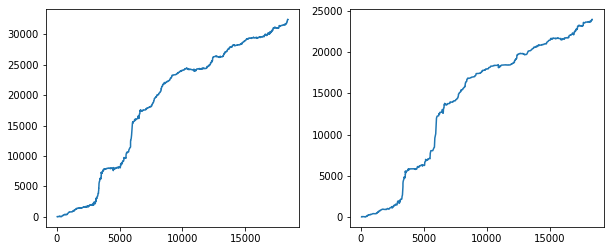

In [23]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
df_filter_vpis['position_pnl_bp'].cumsum().plot(ax=ax1)
df_filter_vpis_conservative['position_pnl_bp'].cumsum().plot(ax=ax2)

In [24]:
sharpe_vpis = df_filter_vpis['position_pnl_bp'].mean() / df_filter_vpis['position_pnl_bp'].std()
sharpe_vpis_conservative = df_filter_vpis_conservative['position_pnl_bp'].mean() / df_filter_vpis_conservative['position_pnl_bp'].std()
print('Sharpe with next filters: max position size {} shares, min price ${}, min delta imbalance pct {}%, close status {} is \n{}'.format(max_volume, min_price, min_deltaImbPct, close_status, sharpe_vpis))
print('Sharpe with next filters: max position size {} shares, min price ${}, min delta imbalance pct {}%, close status {} is \n{}'.format(max_volume, min_price, min_deltaImbPct_conservative, close_status, sharpe_vpis_conservative))

Sharpe with next filters: max position size 900 shares, min price $20, min delta imbalance pct 1.8%, close status moc is 
0.25197150650900413
Sharpe with next filters: max position size 900 shares, min price $20, min delta imbalance pct 3%, close status moc is 
0.28802776256622625


## Seasonality analysis

And as a lst part of analysis I want to do seasonality analysis. What I mean is usually on Friday the moc trading is more active due to final trading day of the week and some triple and quadruple witchings. I expect to see higher pnl on average on Fridays.  

In [25]:
df_filter_vpis['timeindex'] = pd.to_datetime(df_filter_vpis['date'])
df_filter_vpis['day_name'] = df_filter_vpis['timeindex'].map(lambda row: row.strftime("%A"))

df_filter_vpis_conservative['timeindex'] = pd.to_datetime(df_filter_vpis_conservative['date'])
df_filter_vpis_conservative['day_name'] = df_filter_vpis_conservative['timeindex'].map(lambda row: row.strftime("%A"))

In [26]:
df_day_group = pd.DataFrame()
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
df_day_group['count'] = df_filter_vpis.groupby('day_name')['position_pnl_bp'].count().reindex(day_names)
df_day_group['avg_pnl'] = df_filter_vpis.groupby('day_name')['position_pnl_bp'].mean().reindex(day_names)
df_day_group['sum_pnl'] = df_filter_vpis.groupby('day_name')['position_pnl_bp'].sum().reindex(day_names)
df_day_group

,count,avg_pnl,sum_pnl
day_name,,,
Monday,376,18.413453,6923.458485
Tuesday,282,30.805905,8687.265305
Wednesday,244,14.236869,3473.795928
Thursday,264,13.570369,3582.577352
Friday,378,25.863457,9776.386838


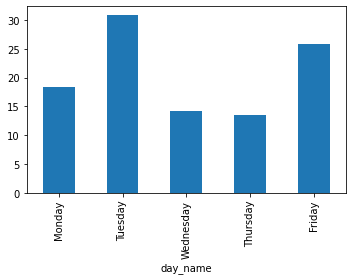

In [27]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(5,4))
df_day_group['avg_pnl'].plot.bar(ax=ax)
fig.tight_layout()

And again we got the confirmation of hypothesis. Friday seems to be the most active due to number of trades and most profitable day by a wide margin.

In [28]:
# Filter
day_filter = 'Friday'
df_filter_vpisd = df_filter_vpis[df_filter_vpis['day_name']==day_filter].copy()
df_filter_vpisd_conservative = df_filter_vpis_conservative[df_filter_vpis_conservative['day_name']==day_filter].copy()

<AxesSubplot:>

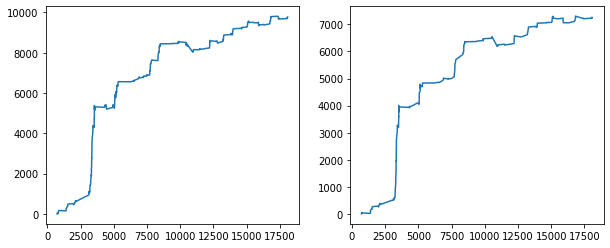

In [29]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
df_filter_vpisd['position_pnl_bp'].cumsum().plot(ax=ax1)
df_filter_vpisd_conservative['position_pnl_bp'].cumsum().plot(ax=ax2)

In [30]:
sharpe_vpisd = df_filter_vpisd['position_pnl_bp'].mean()/df_filter_vpisd['position_pnl_bp'].std()
sharpe_vpisd_conservative = df_filter_vpisd_conservative['position_pnl_bp'].mean()/df_filter_vpisd_conservative['position_pnl_bp'].std()
print('Sharpe with next filters: max position size {} shares, min price ${}, min delta imbalance pct {}%, close status {}, day {} is \n{}'.format(max_volume, min_price, min_deltaImbPct, close_status, day_filter, sharpe_vpisd))
print('Sharpe with next filters: max position size {} shares, min price ${}, min delta imbalance pct {}%, close status {}, day {} is \n{}'.format(max_volume, min_price, min_deltaImbPct_conservative, close_status, day_filter, sharpe_vpisd_conservative))

Sharpe with next filters: max position size 900 shares, min price $20, min delta imbalance pct 1.8%, close status moc, day Friday is 
0.3350914206034773
Sharpe with next filters: max position size 900 shares, min price $20, min delta imbalance pct 3%, close status moc, day Friday is 
0.3958367796831166


And this is another significant improvement of sharpe.

In [31]:
df_filter_vpisd_resample = pd.DataFrame()
df_filter_vpisd_copy = df_filter_vpisd.copy()
df_filter_vpisd_copy.set_index('timeindex', inplace=True)
df_filter_vpisd_resample['sum'] = df_filter_vpisd_copy['position_pnl_bp'].resample('D').sum()
df_filter_vpisd_resample['cum_sum'] = df_filter_vpisd_resample['sum'].cumsum().fillna(0)

<AxesSubplot:xlabel='timeindex'>

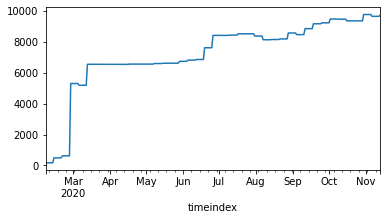

In [32]:
fig, ax = plt.subplots(1, 1)
df_filter_vpisd_resample['cum_sum'].plot(ax=ax)